# **Machine Learning: Convolutional Neural Network Gesture Models**

---

#### **Ryan Harte**

## **Table of Contents**

1. [Introduction](#introduction)
2. [CNN: Project Setup](#cnn-project-setup)
3. [CNN Model: Light from Scratch](#cnn-model-light-from-scratch)
4. [CNN Model: Deep from Scratch](#cnn-model-deep-from-scratch)
5. [CNN Model: Data Augmentation](#cnn-model-data-augmentation)
6. [CNN Model: Data Augmentation Fine Tuned](#cnn-model-data-augmentation-fine-tuned)
7. [CNN Model: Grayscale](#cnn-model-grayscale)

## **Introduction**

This repository features a Jupyter Notebook that explores Convolutional Neural Networks (CNNs) in machine learning. The notebook analyzes a comprehensive dataset of images depicting human hand gestures and training a Neural Network (NN) to accurately recognize them. It is then tested on images of my own hand gestures to assess the NN ability to identify them correctly. The project also includes an evaluation of the model's accuracy and performance.

## **CNN: Project Setup**

In [17]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomZoom, RandomRotation, RandomFlip, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
import cv2
import logging
import warnings
import json


# Suppress warnings from the logging module
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
# Tensorflow Version
print(tf.__version__)

2.10.0


In [3]:
# Check if any GPU devices are detected
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
else:
    print("No GPU detected.")

GPUs detected: 1


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set seed
SEED = 338424

# Global variables
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
num_classes = 18 # Number of folders in dataset
AUTOTUNE = tf.data.AUTOTUNE

#### **Dataset: Loading, Splitting and Shuffling the Data**

In [3]:
# Load Dataset
dataset_dir = 'dataset/hagridset'
full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    seed=SEED,
    image_size=(IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Split into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Total length of the dataset
total_size = len(full_ds)

# Compute indices for the splits
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - (train_size + val_size)

# Split the dataset and shuffle
train_ds = full_ds.take(train_size).shuffle(train_size, seed=SEED)
val_ds = full_ds.skip(train_size).take(val_size).shuffle(val_size, seed=SEED)
test_ds = full_ds.skip(train_size + val_size).shuffle(test_size, seed=SEED)

# Cache the dataset in memory (or use a directory to store it on disk if necessary)
train_ds = full_ds.take(train_size).shuffle(train_size, seed=SEED).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = full_ds.skip(train_size).take(val_size).shuffle(val_size, seed=SEED).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = full_ds.skip(train_size + val_size).cache().prefetch(buffer_size=AUTOTUNE)

# Count samples in each subset
def count_samples(dataset):
    sample_count = sum(1 for _ in dataset.unbatch())
    return sample_count

# Output the number of samples for each dataset
print(f'Using {count_samples(train_ds)} samples in the Training set')
print(f'Using {count_samples(val_ds)} samples in the Validation set')
print(f'Using {count_samples(test_ds)} samples in the Test set')

Found 125912 files belonging to 18 classes.
Using 88128 samples in the Training set
Using 25184 samples in the Validation set
Using 12600 samples in the Test set


In [58]:
path_to_save = 'savedDataset'

tf.data.experimental.save(train_ds, path_to_save + '/train')
tf.data.experimental.save(val_ds, path_to_save + '/val')
tf.data.experimental.save(test_ds, path_to_save + '/test')

In [4]:
# Get class names
class_names = full_ds.class_names
class_names

['call',
 'dislike',
 'fist',
 'four',
 'like',
 'mute',
 'ok',
 'one',
 'palm',
 'peace',
 'peace_inverted',
 'rock',
 'stop',
 'stop_inverted',
 'three',
 'three2',
 'two_up',
 'two_up_inverted']

In [32]:
# Define the Deep CNN Model from Scratch
def build_scratch_cnn_deep_tuned():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values

    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(padding='same'))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3)) 
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
                  optimizer='RMSprop',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Instantiate and summarize the model
scratch_model_deep_tuned = build_scratch_cnn_deep_tuned()
scratch_model_deep_tuned.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_70 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_70 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_71 (Bat  (None, 32, 32, 32)     

In [30]:
# Train Light CNN Model
history_deep_tuned = scratch_model_deep_tuned.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
2754/2754 [==============================] - 57s 20ms/step - loss: 1.8649 - accuracy: 0.4608 - val_loss: 1.2302 - val_accuracy: 0.6833
Epoch 2/10
2754/2754 [==============================] - 59s 21ms/step - loss: 1.1590 - accuracy: 0.7036 - val_loss: 1.0207 - val_accuracy: 0.7522
Epoch 3/10
2754/2754 [==============================] - 59s 21ms/step - loss: 1.0202 - accuracy: 0.7535 - val_loss: 0.9216 - val_accuracy: 0.7875
Epoch 4/10
2754/2754 [==============================] - 59s 21ms/step - loss: 0.9239 - accuracy: 0.7837 - val_loss: 0.8106 - val_accuracy: 0.8214
Epoch 5/10
2754/2754 [==============================] - 59s 21ms/step - loss: 0.8612 - accuracy: 0.8025 - val_loss: 0.8555 - val_accuracy: 0.7978
Epoch 6/10
2754/2754 [==============================] - 57s 21ms/step - loss: 0.8054 - accuracy: 0.8174 - val_loss: 0.7601 - val_accuracy: 0.8339
Epoch 7/10
2754/2754 [==============================] - 59s 21ms/step - loss: 0.7714 - accuracy: 0.8247 - val_loss: 0.6863 -

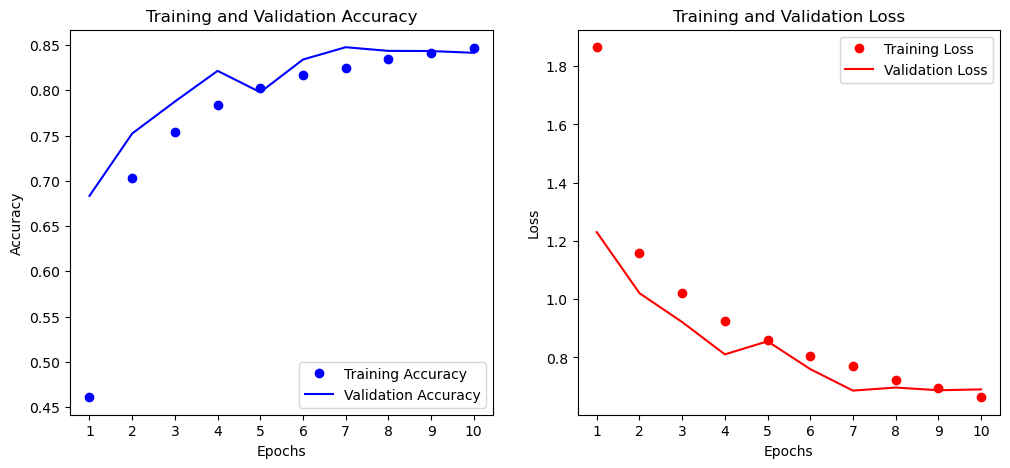

In [31]:
# Access the history dictionary
acc = history_deep_tuned.history['accuracy']
val_acc = history_deep_tuned.history['val_accuracy']
loss = history_deep_tuned.history['loss']
val_loss = history_deep_tuned.history['val_loss']

# Calculate the number of epochs based on the length of any metric list
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

plt.show()

In [24]:
# Define the Light CNN Model from Scratch
def build_scratch_cnn_light_tuned():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values
    
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu')) 
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    # model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))  
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile your model with an initial learning rate
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
    
    return model

# Instantiate and summarize the lighter model
scratch_model_light_tuned = build_scratch_cnn_light_tuned()
scratch_model_light_tuned.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_17 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 64)      

In [25]:
# Define a learning rate schedule
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + 0.01 * epoch)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    LearningRateScheduler(lr_time_based_decay, verbose=1)
]


# Train the model
history_light_tuned = scratch_model_light_tuned.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks  # Include both callbacks here
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
2754/2754 [==============================] - 42s 15ms/step - loss: 1.7847 - accuracy: 0.4352 - val_loss: 1.3343 - val_accuracy: 0.5773 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009900990569281696.
Epoch 2/10
2754/2754 [==============================] - 41s 15ms/step - loss: 0.9253 - accuracy: 0.7039 - val_loss: 0.7572 - val_accuracy: 0.7589 - lr: 9.9010e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009706853341092082.
Epoch 3/10
2754/2754 [==============================] - 41s 15ms/step - loss: 0.6835 - accuracy: 0.7807 - val_loss: 0.6532 - val_accuracy: 0.8009 - lr: 9.7069e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009424129424128428.
Epoch 4/10
2754/2754 [==============================] - 41s 15ms/step - loss: 0.5638 - accuracy: 0.8200 - val_loss: 0.5173 - val_accuracy: 0.8384 - lr: 9.4241e-04

Epoch 5: LearningRateScheduler 

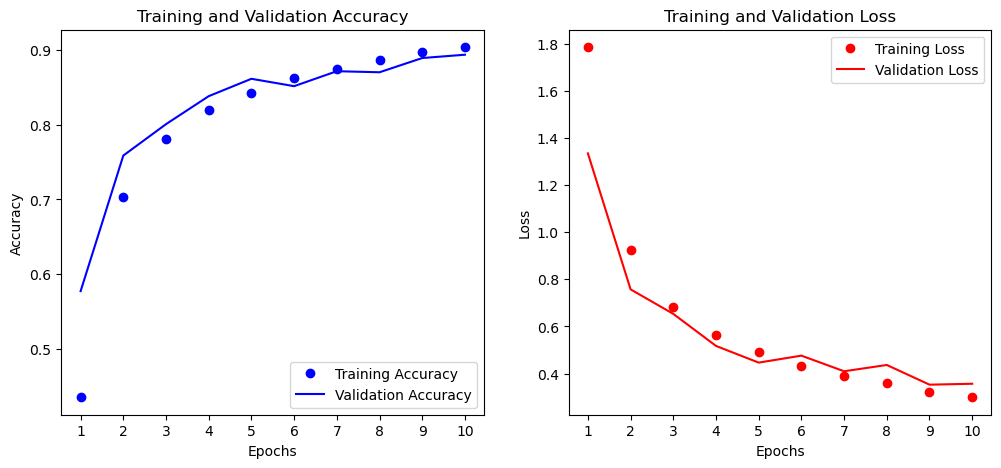

In [26]:
# Access the history dictionary
acc = history_light_tuned.history['accuracy']
val_acc = history_light_tuned.history['val_accuracy']
loss = history_light_tuned.history['loss']
val_loss = history_light_tuned.history['val_loss']

# Calculate the number of epochs based on the length of any metric list
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

plt.show()

In [27]:
# Convert any numpy types to Python lists
for key in history_light_tuned.history.keys():
    history_light_tuned.history[key] = [float(i) for i in history_light_tuned.history[key]]

# Write the JSON file
with open('cnn_model_light_tuned.json', 'w') as f:
    json.dump(history_light_tuned.history, f)

# Save the Deep CNN Model
scratch_model_light_tuned.save('scratch_model_light.h5')

In [13]:
# Data Augmentation
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])

In [14]:
# Define the Light CNN Model from Scratch
def build_scratch_cnn_light_tuned_augmented():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(data_augmentation_layers)
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values
    
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu')) 
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))  
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
                  optimizer='RMSprop',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Instantiate and summarize the lighter model
scratch_model_light_tuned_augmented = build_scratch_cnn_light_tuned_augmented()
scratch_model_light_tuned_augmented.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 32, 32, 32)       

In [15]:
# Train Light CNN Model
history_light_tuned_augmented = scratch_model_light_tuned_augmented.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
2754/2754 [==============================] - 337s 122ms/step - loss: 2.0155 - accuracy: 0.3602 - val_loss: 1.5425 - val_accuracy: 0.5150
Epoch 2/10
2754/2754 [==============================] - 333s 121ms/step - loss: 1.1773 - accuracy: 0.6221 - val_loss: 0.8605 - val_accuracy: 0.7199
Epoch 3/10
2754/2754 [==============================] - 334s 121ms/step - loss: 0.9325 - accuracy: 0.7026 - val_loss: 0.6475 - val_accuracy: 0.7943
Epoch 4/10
 692/2754 [======>.......................] - ETA: 4:04 - loss: 0.8527 - accuracy: 0.7267

KeyboardInterrupt: 

## **CNN Model: Light from Scratch**

In [12]:
# Define the Light CNN Model from Scratch
def build_scratch_cnn_light():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu')) 
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))  
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
                  optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Instantiate and summarize the lighter model
scratch_model_light = build_scratch_cnn_light()
scratch_model_light.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_5 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)       

In [13]:
# Train Light CNN Model
history_light = scratch_model_light.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10


2754/2754 [==============================] - 22s 8ms/step - loss: 2.7768 - accuracy: 0.2348 - val_loss: 2.2440 - val_accuracy: 0.3252
Epoch 2/10
2754/2754 [==============================] - 21s 8ms/step - loss: 1.8417 - accuracy: 0.4150 - val_loss: 1.5863 - val_accuracy: 0.4792
Epoch 3/10
2754/2754 [==============================] - 20s 7ms/step - loss: 1.4732 - accuracy: 0.5254 - val_loss: 1.2721 - val_accuracy: 0.5860
Epoch 4/10
2754/2754 [==============================] - 20s 7ms/step - loss: 1.2346 - accuracy: 0.6004 - val_loss: 0.9905 - val_accuracy: 0.6895
Epoch 5/10
2754/2754 [==============================] - 22s 8ms/step - loss: 1.0857 - accuracy: 0.6495 - val_loss: 1.0082 - val_accuracy: 0.6798
Epoch 6/10
2754/2754 [==============================] - 21s 8ms/step - loss: 0.9952 - accuracy: 0.6780 - val_loss: 0.8479 - val_accuracy: 0.7361
Epoch 7/10
2754/2754 [==============================] - 20s 7ms/step - loss: 0.9265 - accuracy: 0.7018 - val_loss: 0.8053 - val_accuracy: 0.7

In [14]:
# Convert any numpy types to Python lists
for key in history_light.history.keys():
    history_light.history[key] = [float(i) for i in history_light.history[key]]

# Write the JSON file
with open('cnn_model_light.json', 'w') as f:
    json.dump(history_light.history, f)

#### CNN Light Model: Save and Load Model

In [16]:
# Save the Deep CNN Model
scratch_model_light.save('scratch_model_light.h5')

In [17]:
# Load the model
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
scratch_model_light = load_model('scratch_model_light.h5')

## **CNN Model: Deep from Scratch**

In [19]:
# Define the Deep CNN Model from Scratch
def build_scratch_cnn_deep():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values
    
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5)) 
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
                  optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Instantiate and summarize the model
scratch_model_deep = build_scratch_cnn_deep()
scratch_model_deep.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)      

In [20]:
# Train Deep CNN Model
history_deep = scratch_model_deep.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10


2754/2754 [==============================] - 46s 14ms/step - loss: 2.7485 - accuracy: 0.1664 - val_loss: 2.1669 - val_accuracy: 0.3690
Epoch 2/10
2754/2754 [==============================] - 26s 10ms/step - loss: 1.7113 - accuracy: 0.5246 - val_loss: 1.3279 - val_accuracy: 0.6680
Epoch 3/10
2754/2754 [==============================] - 26s 10ms/step - loss: 1.2757 - accuracy: 0.6900 - val_loss: 1.0479 - val_accuracy: 0.7620
Epoch 4/10
2754/2754 [==============================] - 27s 10ms/step - loss: 1.1041 - accuracy: 0.7467 - val_loss: 0.9391 - val_accuracy: 0.7982
Epoch 5/10
2754/2754 [==============================] - 27s 10ms/step - loss: 1.0005 - accuracy: 0.7807 - val_loss: 1.0724 - val_accuracy: 0.7623
Epoch 6/10
2754/2754 [==============================] - 26s 10ms/step - loss: 0.9396 - accuracy: 0.7986 - val_loss: 0.9228 - val_accuracy: 0.8021
Epoch 7/10
2754/2754 [==============================] - 26s 10ms/step - loss: 0.8776 - accuracy: 0.8195 - val_loss: 0.8942 - val_accura

In [22]:
# Convert any numpy types to Python lists
for key in history_deep.history.keys():
    history_deep.history[key] = [float(i) for i in history_deep.history[key]]

# Write the JSON file
with open('cnn_model_deep.json', 'w') as f:
    json.dump(history_deep.history, f)

#### CNN Deep Model: Save and Load Model

In [23]:
# Save the Deep CNN Model
scratch_model_deep.save('scratch_model_deep.h5')

In [24]:
# Load the model
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
scratch_model_deep = load_model('scratch_model_deep.h5')

## **CNN Model: Data Augmentation**

In [9]:
# Data Augmentation
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])

In [29]:
# Define the Deep CNN Model from Scratch
def build_scratch_cnn_da():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(data_augmentation_layers)
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
   
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5)) 
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
                  optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Instantiate and summarize the model
scratch_model_da = build_scratch_cnn_da()
scratch_model_da.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_5 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_19 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 32)       

In [30]:
# Train Deep CNN Model
history_da = scratch_model_da.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
2754/2754 [==============================] - 451s 163ms/step - loss: 2.8682 - accuracy: 0.1280 - val_loss: 2.2481 - val_accuracy: 0.3042
Epoch 2/10
2754/2754 [==============================] - 527s 191ms/step - loss: 2.0021 - accuracy: 0.4070 - val_loss: 1.6024 - val_accuracy: 0.5705
Epoch 3/10
2754/2754 [==============================] - 311s 113ms/step - loss: 1.5182 - accuracy: 0.6055 - val_loss: 1.1555 - val_accuracy: 0.7275
Epoch 4/10
2754/2754 [==============================] - 309s 112ms/step - loss: 1.3078 - accuracy: 0.6843 - val_loss: 1.0098 - val_accuracy: 0.7791
Epoch 5/10
2754/2754 [==============================] - 324s 118ms/step - loss: 1.1945 - accuracy: 0.7219 - val_loss: 0.9408 - val_accuracy: 0.7984
Epoch 6/10
2754/2754 [==============================] - 310s 112ms/step - loss: 1.1172 - accuracy: 0.7462 - val_loss: 0.9711 - val_accuracy: 0.7854
Epoch 7/10
2754/2754 [==============================] - 310s 113ms/step - loss: 1.0651 - accuracy: 0.7613 - val_

In [31]:
# Convert any numpy types to Python lists
for key in history_da.history.keys():
    history_da.history[key] = [float(i) for i in history_da.history[key]]

# Write the JSON file
with open('cnn_model_da.json', 'w') as f:
    json.dump(history_da.history, f)

#### CNN Data Augmentation Model: Save and Load Model 

In [32]:
# Save the Deep CNN Model
scratch_model_da.save('scratch_model_da.h5')

In [33]:
# Load the model
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
scratch_model_da = load_model('scratch_model_da.h5')

## **CNN Model: Data Augmentation Fine-Tuned**

In [34]:
# Define the Deep CNN Model from Scratch
def build_scratch_model_da_adapted_cnn():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(data_augmentation_layers)
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values
    
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
   
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
                  optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Instantiate and summarize the model
scratch_model_da_adapted = build_scratch_model_da_adapted_cnn()
scratch_model_da_adapted.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_25 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 32)       

In [35]:
# Train Deep CNN Model
history_da_adapted = scratch_model_da_adapted.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10


2754/2754 [==============================] - 601s 215ms/step - loss: 1.6664 - accuracy: 0.4671 - val_loss: 1.1762 - val_accuracy: 0.6170
Epoch 2/10
2754/2754 [==============================] - 370s 135ms/step - loss: 0.8278 - accuracy: 0.7325 - val_loss: 0.6399 - val_accuracy: 0.7952
Epoch 3/10
2754/2754 [==============================] - 312s 113ms/step - loss: 0.6425 - accuracy: 0.7933 - val_loss: 0.6069 - val_accuracy: 0.8062
Epoch 4/10
2754/2754 [==============================] - 315s 114ms/step - loss: 0.5419 - accuracy: 0.8256 - val_loss: 0.4798 - val_accuracy: 0.8446
Epoch 5/10
2754/2754 [==============================] - 306s 111ms/step - loss: 0.4762 - accuracy: 0.8459 - val_loss: 0.5335 - val_accuracy: 0.8276
Epoch 6/10
2754/2754 [==============================] - 304s 111ms/step - loss: 0.4341 - accuracy: 0.8587 - val_loss: 0.5785 - val_accuracy: 0.8154
Epoch 7/10
2754/2754 [==============================] - 303s 110ms/step - loss: 0.3924 - accuracy: 0.8722 - val_loss: 0.465

In [36]:
# Convert any numpy types to Python lists
for key in history_da_adapted.history.keys():
    history_da_adapted.history[key] = [float(i) for i in history_da_adapted.history[key]]

# Write the JSON file
with open('cnn_model_da_adapted.json', 'w') as f:
    json.dump(history_da_adapted.history, f)

#### CNN Data Augmentation Model Adapted: Save and Load Model

In [37]:
# Save the Deep CNN Model
scratch_model_da_adapted.save('scratch_model_da_adapted.h5')

In [38]:
# Load the model
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
scratch_model_da_adapted = load_model('scratch_model_da_adapted.h5')

## **CNN Model: Grayscale**

In [84]:
# Load the grayscale dataset separately
full_ds_grayscale = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode='grayscale'  # Load images in grayscale mode
)

# Split the grayscale dataset into training, validation, and test sets
train_size_grayscale = int(train_ratio * len(full_ds_grayscale))
val_size_grayscale = int(val_ratio * len(full_ds_grayscale))
test_size_grayscale = len(full_ds_grayscale) - (train_size_grayscale + val_size_grayscale)

# Shuffle and cache the grayscale datasets
train_ds_grayscale = (full_ds_grayscale.take(train_size_grayscale).shuffle(train_size_grayscale, seed=SEED).cache().prefetch(buffer_size=AUTOTUNE))
val_ds_grayscale = (full_ds_grayscale.skip(train_size_grayscale).take(val_size_grayscale).shuffle(val_size_grayscale, seed=SEED).cache().prefetch(buffer_size=AUTOTUNE))
test_ds_grayscale = (full_ds_grayscale.skip(train_size_grayscale + val_size_grayscale).cache().prefetch(buffer_size=AUTOTUNE))

# Count samples in each grayscale subset
def count_samples(dataset):
    sample_count = sum(1 for _ in dataset.unbatch())
    return sample_count

# Output the number of samples for each grayscale dataset
print(f'Using {count_samples(train_ds_grayscale)} samples in the Grayscale Training set')
print(f'Using {count_samples(val_ds_grayscale)} samples in the Grayscale Validation set')
print(f'Using {count_samples(test_ds_grayscale)} samples in the Grayscale Test set')

Found 125912 files belonging to 18 classes.
Using 88128 samples in the Grayscale Training set
Using 25184 samples in the Grayscale Validation set
Using 12600 samples in the Grayscale Test set


In [87]:
path_to_save = 'savedGrayDataset'

tf.data.experimental.save(train_ds_grayscale, path_to_save + '/train')
tf.data.experimental.save(val_ds_grayscale, path_to_save + '/val')
tf.data.experimental.save(test_ds_grayscale, path_to_save + '/test')

In [85]:
# Define the Grayscale CNN Model from Scratch
def build_scratch_cnn_grayscale():
    model = models.Sequential()
    model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))) # Grayscale input shape
    model.add(layers.Rescaling(1.0 / 255))  # Normalize pixel values
    
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, 3, padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5)) 
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
                  optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

# Instantiate and summarize the model
scratch_model_grayscale = build_scratch_cnn_grayscale()
scratch_model_grayscale.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_23 (Rescaling)    (None, 64, 64, 1)         0         
                                                                 
 conv2d_105 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_96 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_106 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_97 (Bat  (None, 32, 32, 32)     

In [86]:
# Train Deep CNN Model
history_grayscale = scratch_model_grayscale.fit(
    train_ds_grayscale,
    validation_data=val_ds_grayscale,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
2754/2754 [==============================] - 34s 12ms/step - loss: 2.7917 - accuracy: 0.1483 - val_loss: 2.5082 - val_accuracy: 0.2414
Epoch 2/10
2754/2754 [==============================] - 33s 12ms/step - loss: 1.9631 - accuracy: 0.4246 - val_loss: 1.6374 - val_accuracy: 0.5567
Epoch 3/10
2754/2754 [==============================] - 32s 12ms/step - loss: 1.5512 - accuracy: 0.5959 - val_loss: 1.6478 - val_accuracy: 0.5641
Epoch 4/10
2754/2754 [==============================] - 32s 12ms/step - loss: 1.3524 - accuracy: 0.6686 - val_loss: 1.2257 - val_accuracy: 0.7073
Epoch 5/10
2754/2754 [==============================] - 32s 11ms/step - loss: 1.2272 - accuracy: 0.7098 - val_loss: 1.2220 - val_accuracy: 0.7080
Epoch 6/10
2754/2754 [==============================] - 31s 11ms/step - loss: 1.1461 - accuracy: 0.7378 - val_loss: 1.1413 - val_accuracy: 0.7379
Epoch 7/10
2754/2754 [==============================] - 32s 12ms/step - loss: 1.0859 - accuracy: 0.7564 - val_loss: 1.1404 -

In [88]:
# Convert any numpy types to Python lists
for key in history_grayscale.history.keys():
    history_grayscale.history[key] = [float(i) for i in history_grayscale.history[key]]

# Write the JSON file
with open('cnn_model_grayscale.json', 'w') as f:
    json.dump(history_grayscale.history, f)

#### CNN Model Grayscale: Save and Load Model

In [89]:
# Save the Deep CNN Model
scratch_model_grayscale.save('scratch_model_grayscale.h5')

In [14]:
# Load the model
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
scratch_model_grayscale = load_model('scratch_model_grayscale.h5')

# **CNN Model: Transfer Learning VGG-16**

In [75]:
IMAGE_SIZE_TL = (64, 64)
inputs = tf.keras.Input(shape=(IMAGE_SIZE_TL[0], IMAGE_SIZE_TL[1],3))

In [77]:
model_transferlearning = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMAGE_SIZE_TL[0], IMAGE_SIZE_TL[1],3),
    include_top=False)

model_transferlearning.trainable = False
x = data_augmentation_layers(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model_transferlearning(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes)(x)
modeltf = tf.keras.Model(inputs, outputs)

modeltf.compile(
                  optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [78]:
historytf = modeltf.fit(
    train_ds,  
    validation_data=(val_ds), 
    epochs=10, 
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
2754/2754 [==============================] - 343s 124ms/step - loss: 4.9702 - accuracy: 0.2334 - val_loss: 2.5204 - val_accuracy: 0.3194
Epoch 2/10
2754/2754 [==============================] - 338s 123ms/step - loss: 2.8979 - accuracy: 0.2610 - val_loss: 2.5403 - val_accuracy: 0.3126
Epoch 3/10
2754/2754 [==============================] - 338s 123ms/step - loss: 2.9095 - accuracy: 0.2607 - val_loss: 2.5645 - val_accuracy: 0.3131
Epoch 4/10
2754/2754 [==============================] - 339s 123ms/step - loss: 2.9163 - accuracy: 0.2592 - val_loss: 2.4888 - val_accuracy: 0.3204
Epoch 5/10
2754/2754 [==============================] - 340s 123ms/step - loss: 2.9028 - accuracy: 0.2616 - val_loss: 2.5910 - val_accuracy: 0.3095
Epoch 6/10
2754/2754 [==============================] - 340s 123ms/step - loss: 2.9076 - accuracy: 0.2597 - val_loss: 2.5395 - val_accuracy: 0.3170
Epoch 7/10
2754/2754 [==============================] - 338s 123ms/step - loss: 2.9011 - accuracy: 0.2613 - val_

In [79]:
# Convert any numpy types to Python lists
for key in historytf.history.keys():
    historytf.history[key] = [float(i) for i in historytf.history[key]]

# Write the JSON file
with open('cnn_model_vgg16.json', 'w') as f:
    json.dump(historytf.history, f)

In [81]:
# Save the Deep CNN Model
modeltf.save('model_vgg16.h5')

In [ ]:
# Load the model
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
modeltf = load_model('cnn_model_vgg16.h5')

# **Camera**

In [ ]:
# Assuming scratch_model_da2 and class_names are already defined elsewhere
# cap is the VideoCapture object
cap = cv2.VideoCapture(1)

# Adjust camera settings if needed
cap.set(3, 480)  # Adjust width
cap.set(4, 480)  # Adjust height

while True:
    # Read the frame from the camera
    success, img = cap.read()

    # Ensure that the frame was captured successfully before proceeding
    if not success:
        print("Error: Unable to capture video")
        break

    # Resize the image to the desired size
    imgsmall = cv2.resize(img, (128, 128))

    # Prepare the image for prediction
    image = np.array(imgsmall)
    image = image.reshape(1, 128, 128, 3)

    # Predict with your model
    ans = scratch_model_deep.predict(image)
    val = pd.DataFrame(ans, columns=class_names).idxmax(axis=1)

    # Display the prediction on the image
    cv2.putText(img, val.values[0], (0, 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Show the webcam feed
    cv2.imshow("Webcam", img)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()